In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import mglearn
%matplotlib inline

### 2.3.4 나이브 베이즈 분류기

+ **GaussianNB, BernoulliNB, MultinomialNB**
  + GaussianNB : 연속적인 데이터
  + BernoulliNB : 이진 데이터
  + MultinomialNB : 카운트 데이터
+ 선형 분류기 보다 훈련속도가 빠른 편이지만, 일반화 성능이 조금 뒤짐

+ BernoulliNB : 특성중 -이 아닌 것이 몇개인지 셈

In [2]:
X = np.array([[0, 1, 0, 1],
              [1, 0 ,1, 1],
              [0, 0, 0, 1],
              [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])

In [3]:
counts = {}
for label in np.unique(y):
    counts[label] = X[y == label].sum(axis=0)
print('특성 카운트 : \n{}'.format(counts))

특성 카운트 : 
{0: array([0, 1, 0, 2]), 1: array([2, 0, 2, 1])}


+ MultinomialNB : 클래스별로 특성의 평균을 계산
+ GaussianNB: 클래스별로 각 특성의 표준편차와 평균을 저장

#### 장당점과 매개변수 

+ 장단점
  + 훈련과 예측속도가 빠르며 훈련 과정을 이해하기 쉬움
  + 희소한 고차원 데이터에서 잘 작동하며 비교적 매개변수에 민감하지 않음
  + 선형 모델로는 학습시간이 너무 오래 걸리는 매우 큰 데이터셋에는 나이브베이즈 모델을 시도해볼 만함
+ 매개변수
  + alpha : 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가 -> 통계 데이터를 완만하게 만듦 -> 모델의 복잡도 낮아짐 

### 2.3.5 결정 트리

+ 분류와 회귀에 모두 사용됨
+ 결정 트리는 결정에 다다르기 위해 예/아니오 질문을 이어 나가면서 학습함
  + information gain을 통하여 엔트로피를 낮게 만드는 독립 변수와 기준값을 찾음
  + information gain : $ IG[Y,X]=H[Y]−H[Y|X] $ 
  
  
  + $ H[Y] = - \frac{X_1}{X_1 + X_2} log_2 \frac{X_1}{X_1 + X_2} - \frac{X_2}{X_1 + X_2} log_2 \frac{X_2}{X_1 + X_2}$
  
  
  
  + $ H[Y|X] = \frac{1}{2} H[Y|X = X_1] + \frac{1}{2} H[Y|X = X_2] $

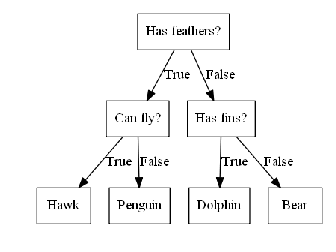

In [4]:
mglearn.plots.plot_animal_tree()

#### 결정트리 만들기

In [38]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)


def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    
    plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], s=80, label=cl)

    plt.legend(loc='upper left')
    plt.title(title)
    
    return Z

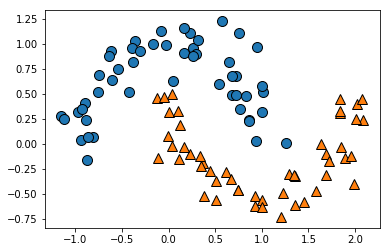

In [39]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, shuffle=True, noise=0.15, random_state=0)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0).fit(X, y)

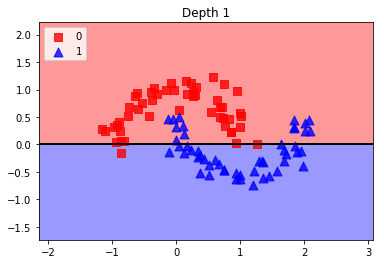

In [41]:
plot_decision_regions(X, y, tree1, "Depth 1")
plt.show()

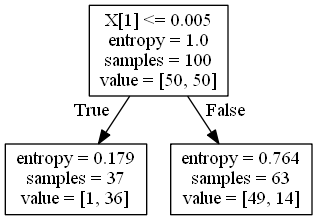

In [42]:
draw_decision_tree(tree1)

#### 결정트리의 복잡도 제어하기

+ 모든 피르 노드가 순수 노드가 될 때까지 진행하면 모델이 매우 복잡해지고 오버피팅이 된다
    + 트리를 일찍 중단하는 사전 가지치기
    + 트리를 만든후 데이터 포인트가 적은 노드를 삭제하거나 병합한느 사후가지치기(가지치기)

+ 유방암 데이터를 이용한 사전 가지치기의 효과 확인
    + 가지치기를 하지 않은 경우 훈련 세트의 정확도는 1이 나오지만 테스트 세트의 정확도는 .94

In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)
print('훈련 세트 정확도 : {:.3f}'.format(tree.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(tree.score(X_test, y_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.944


+ max_dapth 를 4로 제한시킨 결과 테스트 세트의 정확도가 높아짐

In [50]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0).fit(X_train, y_train)
print('훈련 세트 정확도 : {:.3f}'.format(tree.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(tree.score(X_test, y_test)))

훈련 세트 정확도 : 0.986
테스트 세트 정확도 : 0.958


#### 결정트리의 분석

In [61]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', class_names=['N', 'T'], 
                feature_names=cancer.feature_names, impurity=False, filled=True)

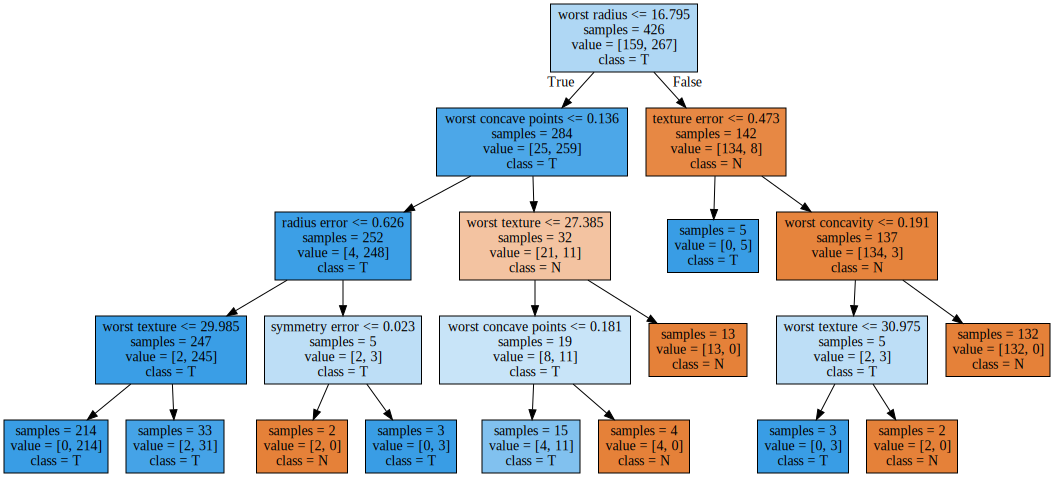

In [62]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### 트리의 특성 중요도 

In [65]:
print('특성 중요도 : \n{}'.format(tree.feature_importances_))

특성 중요도 : 
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.02093242  0.06165377  0.          0.
  0.          0.          0.          0.          0.01268893  0.
  0.62610311  0.05695529  0.          0.          0.          0.          0.0417274
  0.17993908  0.          0.        ]


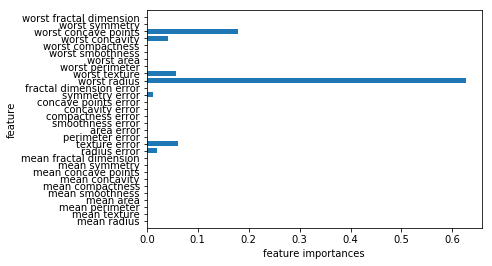

In [68]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel('feature importances')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

Feature importances: [ 0.  1.]


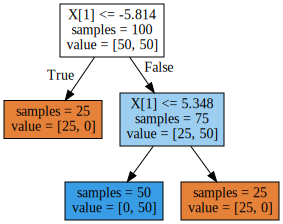

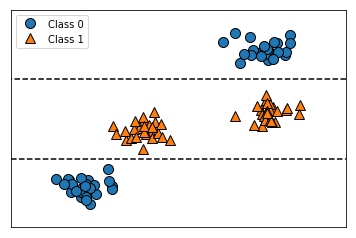

In [70]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)